# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [12]:
#RNN: Neural network where each element that came before an entry is used in the modelling.

In [13]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data (we will be using a special function in keras)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('/Users/JacobRaymond 1/Desktop/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]

#Labelling
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [14]:
# Install keras
!pip install -U keras

Requirement already up-to-date: keras in /opt/anaconda3/lib/python3.8/site-packages (2.4.3)


In [15]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
# Initialize and fit the tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
# Use that tokenizer to transform the text messages in the training and test sets
#Automatically cleans the data, transforms it to integers, and puts into an array of arrays
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [18]:
# What do these sequences look like?
#This is the integer representation of the first message
X_train_seq[0]

[130,
 1,
 32,
 31,
 1252,
 5,
 416,
 2009,
 76,
 9,
 12,
 4,
 3776,
 1,
 124,
 12,
 3777,
 8,
 2010,
 97,
 431,
 178,
 3778,
 1016,
 23,
 228,
 3779,
 2,
 31,
 1252,
 83,
 26]

In [19]:
# Pad the sequences so each sequence is the same length
#Each sequence will be of length 50 (either truncated or padded)
X_train_seq_padded=pad_sequences(X_train_seq, 50)
X_test_seq_padded=pad_sequences(X_test_seq, 50)

In [20]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  130,    1,   32,   31,
       1252,    5,  416, 2009,   76,    9,   12,    4, 3776,    1,  124,
         12, 3777,    8, 2010,   97,  431,  178, 3778, 1016,   23,  228,
       3779,    2,   31, 1252,   83,   26], dtype=int32)

### Build Model

In [21]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [26]:
# Construct a simple RNN model
model = Sequential()

#Layers are somewhat arbitrary
# First layer: Creates a vector representation and apply rf (like w2v or d2v)
#First element: number of words; Second: vector of length 32
model.add(Embedding(len(tokenizer.index_word)+1, 32))
#Second layer: LSTM model
#First element: output size; Second and third: regularization to avoid overfitting. We drop nodes. No regularization at this point.
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
#Third layer: Dense layer
#First element: output size; Second: activation function
model.add(Dense(32, activation='relu'))
#Last layer: sigmoid function (for prediction)
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          252960    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 262,369
Trainable params: 262,369
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [28]:
# Fit the RNN model
#10 epoch: runs the model 10 times.
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 41ms/step - loss: 0.3104 - accuracy: 0.9049 - precision_m: 0.4294 - recall_m: 0.3755 - val_loss: 0.0739 - val_accuracy: 0.9812 - val_precision_m: 0.9771 - val_recall_m: 0.8845
Epoch 2/10
140/140 [==============================] - 5s 38ms/step - loss: 0.0427 - accuracy: 0.9892 - precision_m: 0.9675 - recall_m: 0.9413 - val_loss: 0.0595 - val_accuracy: 0.9830 - val_precision_m: 1.0000 - val_recall_m: 0.8945
Epoch 3/10
140/140 [==============================] - 5s 35ms/step - loss: 0.0148 - accuracy: 0.9969 - precision_m: 0.9830 - recall_m: 0.9698 - val_loss: 0.0627 - val_accuracy: 0.9839 - val_precision_m: 0.9905 - val_recall_m: 0.9123
Epoch 4/10
140/140 [==============================] - 5s 37ms/step - loss: 0.0058 - accuracy: 0.9982 - precision_m: 0.9879 - recall_m: 0.9831 - val_loss: 0.0689 - val_accuracy: 0.9839 - val_precision_m: 1.0000 - val_recall_m: 0.9088
Epoch 5/10
140/140 [==============================] - 5s 35ms/step -

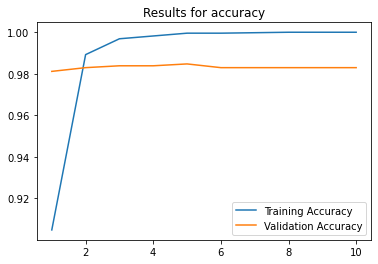

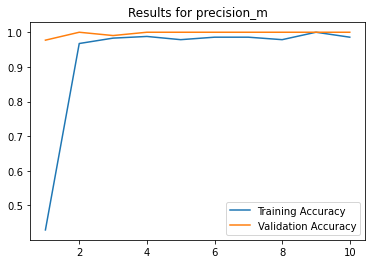

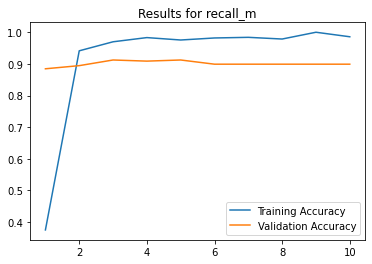

In [29]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()
    
#10 epochs is not necessary
#No overfitting.